![CC](https://i.creativecommons.org/l/by/4.0/88x31.png)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

# SVD of the flow past a circular cylinder

In this notebook, we perform a singular value decomposition (SVD) of the flow past a cylinder. The Reynolds number based on the cylinder's diameter $d$, the average inlet velocity $U_m$, and the kinematic viscosity $\nu$ is:

$$
  Re = \frac{U_m d}{\nu} = 100.
$$
The simulation was conducted in *OpenFOAM*. The simulation domain is shown in the sketch below. All dimensions are given in terms of cylinder diameters. The sketch is taken from Darshan Thummar's [report on active flow control](https://zenodo.org/record/4897961#.YLuzdzqxVH4) (figure 2.1).

<img src="figures/cylinder_domain.svg" width=800 />

The goal of this tutorial is to demonstrate:
- how to assemble a data matrix based on a selected subset of a scalar field time series
- how to use the SVD to extract coherent structures from the **vorticity** field

## Importing libraries

In [1]:
import bisect
import torch as pt
import matplotlib.pyplot as plt
import matplotlib as mpl
from flowtorch import DATASETS
from flowtorch.data import FOAMDataloader, mask_box
from flowtorch.analysis import SVD

# increase resolution of plots
mpl.rcParams['figure.dpi'] = 160

## Assembling the data matrix

To create the data matrix, we will:
- investigate the available fields and write times
- create a mask to select a subset of the domain
- load vorticity snapshots and apply the mask; each snapshot forms a column of the data matrix
- subtract the temporal mean

### Inspecting the available data

Without the time '0', the data cosists of 400 snapshots. Except for the zero folder, all time folders contain pressure, vorticity, surface flux (phi), and velocity.

In [2]:
path = DATASETS["of_cylinder2D_binary"]
loader = FOAMDataloader(path)
times = loader.write_times
fields = loader.field_names
print(f"Number of available snapshots: {len(times)}")
print("First five write times: ", times[:5])
print(f"Fields available at t={times[-1]}: ", fields[times[-1]])

Number of available snapshots: 401
First five write times:  ['0', '0.025', '0.05', '0.075', '0.1']
Fields available at t=10:  ['p', 'vorticity', 'phi', 'U']


### Creating a mask

The full computational domain extends 22 diameters in $x$-direction. For the present flow analysis, we reduce the spatial domain to $1d$ before and $7.5d$ after the cylinder's center. The physical diameter in the simulation is $d=0.1m$. Therefore, we create a rectangular mask extending from $x_{min}=0.1m$ to $x_{max}=0.75m$. The $y$-bounds should be large enough to include the entire domain. The $z$-direction is discarded since the simulation is only 2D.

In [3]:
# load vertices and discard z-coordinate
vertices = loader.vertices[:, :2]
mask = mask_box(vertices, lower=[0.1, -1], upper=[0.75, 1])

Could not find precomputed cell centers and volumes.
Computing cell geometry from scratch (slow, not recommended for large meshes).
To compute cell centers and volumes in OpenFOAM, run:

postProcess -func "writeCellCentres" -constant -time none
postProcess -func "writeCellVolumes" -constant -time none


When loading the vertices, the *loader* prints a warning message stating that we did not precompute cell centers and volumes. For small meshes, say less than $10^5$ cells, the computation can be performed without any problems in *flowTorch*. However, for larger meshes, it is much more efficient to use the dedicated *OpenFOAM* function objects. The mask is a 1D boolean tensor whose elements are `True` if the corresponding vertex is located within the specified bounds. Summing up the mask's elements yields the number of selected vertices (`True` and `False` are cast to 1 and 0, respectively).

In [4]:
print(f"Selected vertices: {mask.sum().item()}/{mask.shape[0]}")

Selected vertices: 7190/13678


We can visualize the selected vertices using a simple scatter plot. For larger meshes and 3D data, it is more convinient to save the mask in the *flowTorch* HDF5 format and to visualize it in *ParaView*.

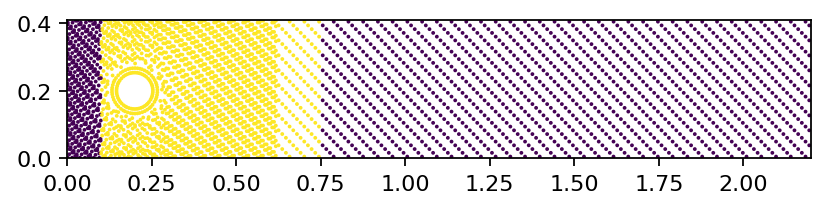

In [5]:
every = 4 # use only every 4th vertex
fig, ax = plt.subplots()
ax.scatter(vertices[::every, 0], vertices[::every, 1], s=0.5, c=mask[::every])
ax.set_aspect("equal", 'box')
ax.set_xlim(0.0, 2.2)
ax.set_ylim(0.0, 0.41)
plt.show()

### Loading the snapshots and extracting the mean

The vortex shedding starts approximately at $t=1.5s$ and is fully developed after $t\approx 4s$. To build the data matrix, we use the remaining 241 snapshots $t\ge 4.0s$. The vorticity is a vectorial field. However, since the simulation is 2D, only the $z$-component contains non-zero entries. Therefore, the resulting data matrix has the dimension **number of selected vertices** x **number of snapshots**. It is common to perform the SVD analysis only on the fluctuating component of the data. Therefore, we extract the temporal mean of the vorticity. However, we could perform the same analysis without this step and would get only slightly different modes (mode zero would become the steady component and all other modes would be shifted by one).

In [6]:
window_times = [time for time in times if float(time) >= 4.0]
data_matrix = pt.zeros((mask.sum().item(), len(window_times)), dtype=pt.float32)
for i, time in enumerate(window_times):
    # load the vorticity vector field, take the z-component [:, 2], and apply the mask
    data_matrix[:, i] = pt.masked_select(loader.load_snapshot("vorticity", time)[:, 2], mask)
    
# subtract the temporal mean
data_matrix -= pt.mean(data_matrix, dim=1).unsqueeze(-1)

## Singular value decomposition

In the last part of this tutorial, we compute the SVD of the data matrix and visualize the right/left singular vectors and the singular values. The SVD object automatically performs a so-called rank-truncation. The rank can be prescribed when the SVD object is created. Otherwise, the rank is estimated automatically; see [M. Gavish and D. L. Donoho (2014)](https://ieeexplore.ieee.org/document/6846297) or the tutorial on [Optimal hard threshold for singular values](svd_ht.ipynb) for more information. For now, we use the full rank by setting the *rank* parameter to a value that is equal to or larger than the number of snapshots we used.

In [7]:
svd = SVD(data_matrix, rank=400)
print(svd)

SVD of a 7190x241 data matrix
Selected/optimal rank: 241/97
data type: torch.float32 (4b)
truncated SVD size: 6.8326Mb


### Singular values

The singular values indicate the importance of the corresponding left and right singular vectors in the factorization of the data matrix. It is common practice to plot the relative contribution of each singular value to the full factorization. Another common mean of visualization is the cumulative contribution of the first $n$ singular values to the full data.

In [8]:
s = svd.s
s_sum = s.sum().item()
# relative contribution
s_rel = [s_i / s_sum * 100 for s_i in s]
# cumulative contribution
s_cum = [s[:n].sum().item() / s_sum * 100 for n in range(s.shape[0])]
# find out how many singular values we need to reach at least 99 percent
i_99 = bisect.bisect_right(s_cum, 99)

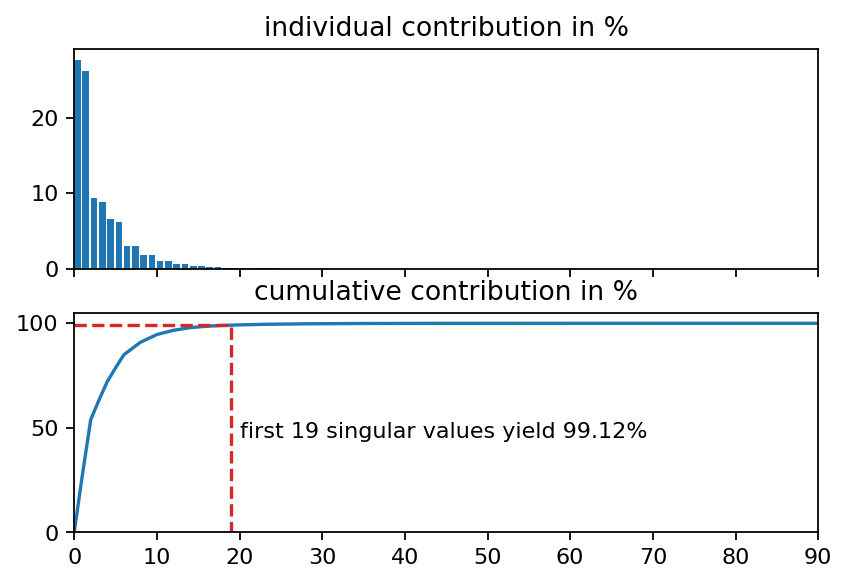

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.bar(range(s.shape[0]), s_rel, align="edge")
ax2.plot(range(s.shape[0]), s_cum)
ax2.set_xlim(0, 90)
ax2.set_ylim(0, 105)
ax1.set_title("individual contribution in %")
ax2.set_title("cumulative contribution in %")
ax2.plot([0, i_99, i_99], [s_cum[i_99], s_cum[i_99], 0], ls="--", color="C3")
ax2.text(i_99+1, 45, "first {:d} singular values yield {:1.2f}%".format(i_99, s_cum[i_99]))
plt.show()

### Left singular vectors

In the context of proper orthogonal decomposition (POD), the left singular vectors would be called **POD modes**. Each column of the *U* tensor has the same size as a masked snapshot used to assemble the data matrix. Moreover, the modes are automatically ordered according to their contribution, meaning that the first column/mode contains more information (more variance) than the second one and so on. Since the data is 2D, we can visualize the modes using a **contour plot**. For a cleaner visualization, it is recommended to use *ParaView* instead. The modes are very similar to those depicted in section 2.3.2 of [Dynamic Mode Decomposition: Data-Driven Modeling of Complex Systems](https://epubs.siam.org/doi/book/10.1137/1.9781611974508).

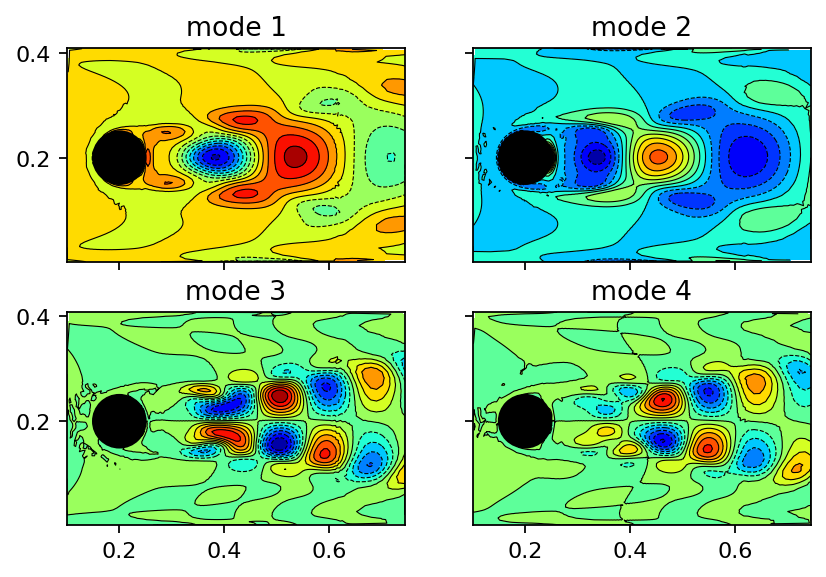

In [10]:
x = pt.masked_select(vertices[:, 0], mask)
y = pt.masked_select(vertices[:, 1], mask)

fig, axarr = plt.subplots(2, 2, sharex=True, sharey=True)
count = 0
for row in range(2):
    for col in range(2):
        axarr[row, col].tricontourf(x, y, svd.U[:, count], levels=14, cmap="jet")
        axarr[row, col].tricontour(x, y, svd.U[:, count], levels=14, linewidths=0.5, colors='k')
        axarr[row, col].add_patch(plt.Circle((0.2, 0.2), 0.05, color='k'))
        axarr[row, col].set_aspect("equal", 'box')
        # add 1 for the POD mode number since we subtracted the mean
        axarr[row, col].set_title(f"mode {count + 1}")
        count += 1
plt.show()

### Right singular vectors

The right singular vectors reflect the temporal evolution of the corresponding left singular vectors. We can plot each column of the *V* matrix over time. Multiplying the left singular vectors with the corresponding singular values yields the so-called **POD mode coefficients**, which are depicted below.

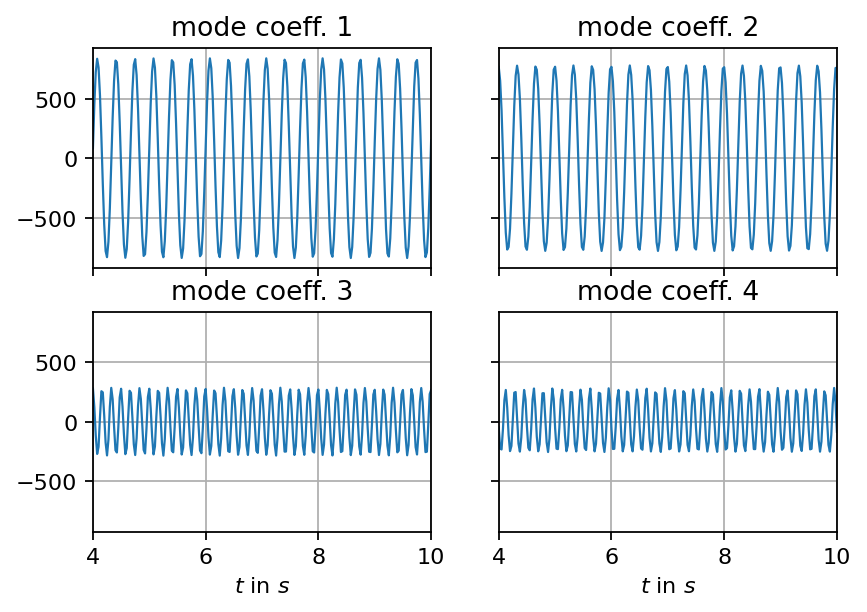

In [11]:
times_num = [float(time) for time in window_times]

fig, axarr = plt.subplots(2, 2, sharex=True, sharey=True)
count = 0
for row in range(2):
    for col in range(2):
        axarr[row, col].plot(times_num, svd.V[:, count]*svd.s[count], lw=1, label=f"coeff. mode {i+1}")
        axarr[row, col].set_xlim(min(times_num), max(times_num))
        axarr[row, col].grid()
        # add 1 for the POD mode number since we subtracted the mean
        axarr[row, col].set_title(f"mode coeff. {count + 1}")
        count += 1
for ax in axarr[1, :]:
    ax.set_xlabel(r"$t$ in $s$")
plt.show()